In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import probplot
from scipy.stats import linregress

import warnings
warnings.simplefilter('ignore')

In [12]:
## Calulcating metrics
def calculate_metrics(df, crop_names, y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test,y_pred)
    y_test_avg = pd.DataFrame(y_test).mean().iloc[0]
    y_pred_avg = pd.DataFrame(y_pred).mean().iloc[0]
    df.loc[crop_names] = [mae, mse, rmse, mape, r2, y_test_avg, y_pred_avg]


In [13]:
fao_data = pd.read_csv("datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Rodenticides – Other-3,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Bipiridils-3,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Herbicides – Sulfonyl ureas-3,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2,Rodenticides – Anti-coagulants-3
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,5.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,0.0,0.0,0.0,Sunflower seed,-0.8656,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,-81.0,0.0,0.0,31.0,0.41,0.41,0.41
2020-01-01,-106607.0,-55584.0,26854.0,Hop cones,0.2323,-15.0,-241.0,142.0,140.0,-773.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.41,0.41,0.41
2020-01-01,0.0,0.0,0.0,Rape or colza seed,1.4064,0.0,0.0,0.0,0.0,0.0,...,0.0,-84.0,0.0,0.0,4.0,0.0,0.0,0.10,0.41,0.41
2020-01-01,0.0,0.0,0.0,Soya beans,-1.0056,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-84.0,0.0,0.0,4.0,0.0,0.10,0.10,0.41


In [4]:
fao_data[['Category']]

,Category
1990-01-01,Fruits and Nuts
1990-01-01,Fruits and Nuts
1990-01-01,Fruits and Nuts
1990-01-01,Fruits and Nuts
1990-01-01,Fruits and Nuts
...,...
2019-01-01,Industrial_crops
2020-01-01,Industrial_crops
2020-01-01,Industrial_crops
2020-01-01,Industrial_crops


In [5]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals',
       'Industrial_crops'], dtype=object)

In [6]:
quality_metrics = ['SVR_MAE', 'SVR_MSE', 'SVR_RMSE', 'SVR_MAPE', 'SVR_r2_score', 'y_test_avg', 'y_pred_avg']
error_df = pd.DataFrame(columns = quality_metrics, index = cat_names)
#display(error_df)

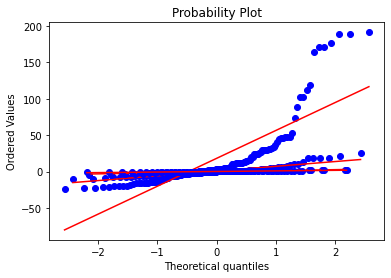

In [16]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')

    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    

    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)

    x = scaler.fit_transform(x)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    regressor = SVR(kernel='rbf', C = 100, epsilon= 0.15)
    regressor.fit(x_train, y_train)


    #prediction of new value
    y_pred = regressor.predict(x_test)
    # model evaluation per crop
    calculate_metrics(error_df, cat , y_test, y_pred) 
   # display(pd.DataFrame(x))
    # testing normaility of data per crop
    residuals = y_test['Yield(tonnes/ha)'] - regressor.predict(x_test)
    probplot(residuals, dist="norm", plot=plt) 
    # checking linearity per crop
    # Loop over each independent variable and plot against the dependent variable

    # for col in range(0, 28):
    #     X = pd.DataFrame(x)[col]
    #     slope, intercept, rvalue, pvalue, stderr = linregress(X, y)
    #     plt.scatter(X, y, alpha=0.5)
    #     plt.plot(X, slope * X + intercept, color='red')
    #     plt.title(f'{col} vs.  Yield for {crop}')
    #     plt.xlabel(col)
    #     plt.ylabel('Yield')
    #     plt.show()


In [17]:
error_df

,SVR_MAE,SVR_MSE,SVR_RMSE,SVR_MAPE,SVR_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,4.663607,47.285571,6.87645,0.573181,0.066219,9.62286,8.934872
Vegetables and Legumes,26.089636,2436.317081,49.359063,1.115178,0.31656,45.745672,27.541809
Cereals,0.96741,2.420736,1.555871,0.840695,0.585271,0.038645,0.325266
Industrial_crops,0.590533,0.589824,0.768,1.535628,0.660377,0.030727,-0.088073
